# Project 3

This project requires the implementation of an image classifier based on convolutional neural networks. The provided dataset (from [Lazebnik et al., 2006]),
contains 15 categories (office, kitchen, living room, bedroom, store, industrial,
tall building, inside city, street, highway, coast, open country, mountain, forest,
suburb), and is already divided in training set and test set

### 1. train a shallow network

Read the images from the train data set

In [103]:
import cv2 as cv2
import glob

path_train=r'C:\Users\eleon\Documents\Uni_Trieste\DSSC_II_year_I_semester\Computer Vision\Exam\train'
path_test=r'C:\Users\eleon\Documents\Uni_Trieste\DSSC_II_year_I_semester\Computer Vision\Exam\test'

In [104]:
import os
import numpy as np

labels=[os.path.basename(dir) for dir in glob.glob(path_train + '/*', recursive=True)]
train_y=[]
train_x=[]

for idx,i in enumerate(labels):
    for im in glob.glob(path_train + '/'+ i +'/*.jpg', recursive=True):
        #train_x.append(cv2.imread(im))
        train_x.append(cv2.cvtColor(cv2.imread(im),cv2.COLOR_BGR2GRAY))
        train_y.append(idx)

In [105]:
(labels)

['Bedroom',
 'Coast',
 'Forest',
 'Highway',
 'Industrial',
 'InsideCity',
 'Kitchen',
 'LivingRoom',
 'Mountain',
 'Office',
 'OpenCountry',
 'Store',
 'Street',
 'Suburb',
 'TallBuilding']

In [106]:
test_y=[]
test_x=[]

for idx,i in enumerate(labels):
    for im in glob.glob(path_test + '/'+ i +'/*.jpg', recursive=True):
        test_x.append(cv2.cvtColor(cv2.imread(im),cv2.COLOR_BGR2GRAY))
        #test_x.append(cv2.imread(im))
        test_y.append(idx)

Using anisotropic rescaling, resize the images to 64x64 in order to feed them to the network

In [107]:
width = 64
height = 64
channel = 1
dim = (width, height)
#INTER_AREA – resampling using pixel area relation
train_r_x = np.array([cv2.resize(im, dim, interpolation = cv2.INTER_AREA) for im in train_x])
test_r_x = np.array([cv2.resize(im, dim, interpolation = cv2.INTER_AREA) for im in test_x])

train_r_x = np.array([np.reshape(im,(64,64,channel)) for im in train_r_x])
test_r_x = np.array([np.reshape(im, (64,64,channel)) for im in test_r_x])

print('Original Dimensions : ',train_x[0].shape) 
print('Resized Dimensions : ',train_r_x[0].shape)

Original Dimensions :  (200, 267)
Resized Dimensions :  (64, 64, 1)


Print a sample image to check the correctness of the procedure

In [108]:
cv2.imshow("Resized image", train_x[9])
cv2.imshow("Not resized image", train_r_x[9])
cv2.waitKey(0)
cv2.destroyAllWindows()
#note: remember to close the images to procede

Use One-Hot Encoding to convert the labels into a set of 10 numbers to input into the neural network.

In [109]:
from keras.utils import to_categorical
y_train_one_hot = to_categorical(train_y)
y_test_one_hot = to_categorical(test_y)

Rescale the images from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values

In [110]:
train_r_x = train_r_x / 255
test_r_x = test_r_x / 255

In [111]:
print('len train x: ',len(train_r_x))
print('len test x: ',len(test_r_x))
print('len train y: ',len(y_train_one_hot))
print('len test y: ',len(y_test_one_hot))

len train x:  1500
len test x:  2985
len train y:  1500
len test y:  2985


Split the training set between train 85% and validation set 15%

In [112]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(
    train_r_x, y_train_one_hot, train_size=0.85, random_state=42)

In [113]:
print('Train set dimintion: ',len(X_train))
print('Validation set dimintion: ',len(X_validation))

Train set dimintion:  1275
Validation set dimintion:  225


Employ the stochastic gradient descent with momentum optimization
algorithm, using the default parameters of the library you use, but use minibatches of size 32 and initial weights drawn from a Gaussian distribution with a mean of 0 and a standard deviation of 0.01; set the initial bias values to 0


In [114]:
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

To build the model we need to create the architecture using Sequential()  and add the first layer, a convolution layer to extract features from the input image

In [175]:
num_classes = 15
norm = ks.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
sgd = ks.optimizers.SGD(momentum=0.7,nesterov=True)

def model1():
    model = Sequential([
        Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Conv2D(16, 3,strides=1, padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Conv2D(32, 3,strides=1, padding='same'),
        Activation('relu'),
        Flatten(),
        Dense(num_classes, activation='softmax',kernel_initializer=norm, bias_initializer='zeros')
    ])
    sgd = ks.optimizers.SGD(momentum=0.7,nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ['accuracy'])
    return model

Compile the model, we choose the SGD momentum optimizer and binary cross entropy loss function

Visualize training results, since we don't know the best number of epochs we compute e stopping critera 

In [176]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=5)
batch_sz = 32

history=model1().fit(
    X_train,
    y_train,
    batch_size=batch_sz,
    epochs=20,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

Train on 1275 samples, validate on 225 samples
Epoch 1/20
1275/1275 [==============================] - 4s 3ms/step - loss: 2.7087 - accuracy: 0.0667 - val_loss: 2.7007 - val_accuracy: 0.1244
Epoch 2/20
1275/1275 [==============================] - 4s 3ms/step - loss: 2.6884 - accuracy: 0.1098 - val_loss: 2.6786 - val_accuracy: 0.1600
Epoch 3/20
1275/1275 [==============================] - 4s 3ms/step - loss: 2.6498 - accuracy: 0.1553 - val_loss: 2.6175 - val_accuracy: 0.1156
Epoch 4/20
1275/1275 [==============================] - 4s 3ms/step - loss: 2.5443 - accuracy: 0.1820 - val_loss: 2.4932 - val_accuracy: 0.2044
Epoch 5/20
1275/1275 [==============================] - 4s 4ms/step - loss: 2.4127 - accuracy: 0.2125 - val_loss: 2.4472 - val_accuracy: 0.2000
Epoch 6/20
1275/1275 [==============================] - 4s 3ms/step - loss: 2.3172 - accuracy: 0.2612 - val_loss: 2.3071 - val_accuracy: 0.2800
Epoch 7/20
1275/1275 [==============================] - 4s 3ms/step - loss: 2.2371 - accu

Plot the results

In [118]:
def plot_acc_loss(history,n):    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(n)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


ValueError: x and y must have same first dimension, but have shapes (18,) and (19,)

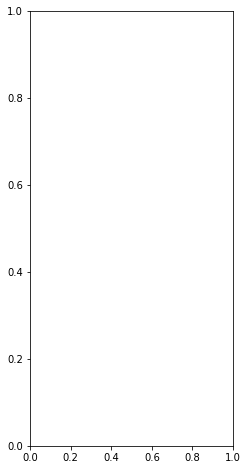

In [119]:
plot_acc_loss(history,18)
plt.savefig("accurancy and loss first model");

Print the accurancy and loss for the test set

In [120]:
y_pred = model1().predict_classes(test_r_x)

loss0,accuracy0 = model1().evaluate(test_r_x,y_test_one_hot)
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

2985/2985 [==============================] - 2s 726us/step
loss: 2.43
accuracy: 0.33


Plot normalized confusion matrix

In [121]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix(test_y,y_pred):
    cm=confusion_matrix(test_y, y_pred)
    # Normalize the confusion matrix so that each row sums to 1.
    cm = tf.cast(cm, dtype=tf.float32)
    cm = cm / tf.math.reduce_sum(cm, axis=1)[:, np.newaxis]
    plt.figure(figsize=(18,13))
    sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels);
    plt.xlabel("Predicted");
    plt.ylabel("True");

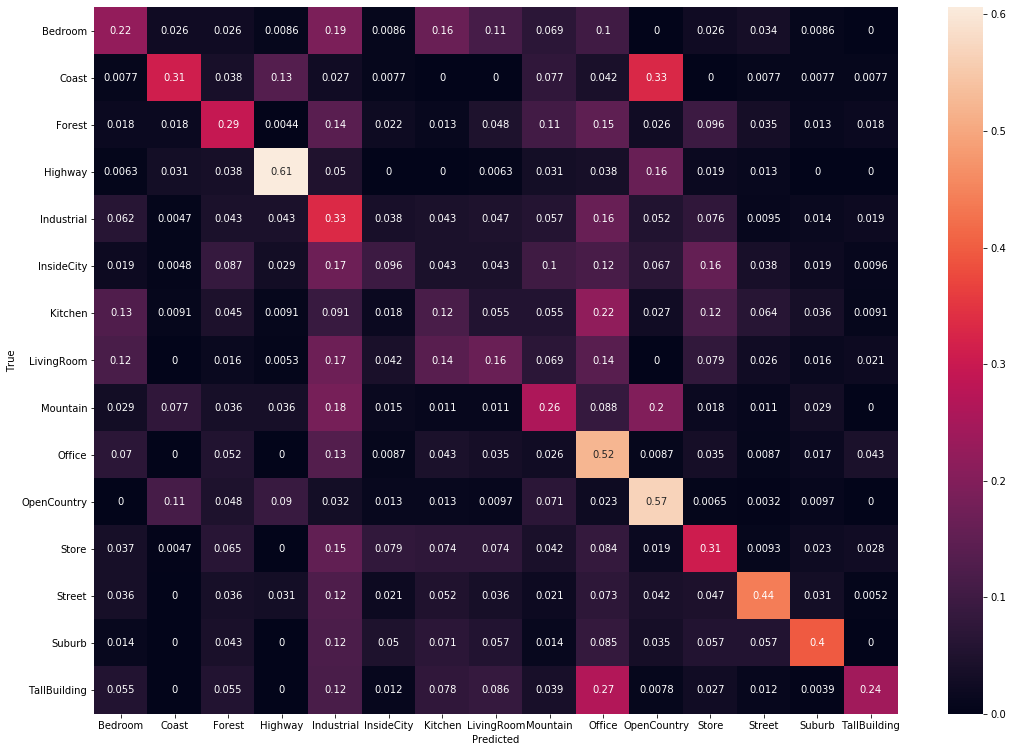

In [122]:
y_pred = model1().predict_classes(test_r_x)
plot_confusion_matrix(test_y,y_pred)
plt.savefig("confusion matrix first model");

In [123]:

from sklearn.metrics import classification_report
print('Classification Report')
print(classification_report(test_y, y_pred, target_names=labels))

Classification Report
              precision    recall  f1-score   support

     Bedroom       0.20      0.22      0.21       116
       Coast       0.53      0.31      0.39       260
      Forest       0.35      0.29      0.32       228
     Highway       0.50      0.61      0.55       160
  Industrial       0.18      0.33      0.23       211
  InsideCity       0.23      0.10      0.14       208
     Kitchen       0.09      0.12      0.10       110
  LivingRoom       0.22      0.16      0.19       189
    Mountain       0.31      0.26      0.28       274
      Office       0.16      0.52      0.25       115
 OpenCountry       0.44      0.57      0.50       310
       Store       0.32      0.31      0.31       215
      Street       0.60      0.44      0.51       192
      Suburb       0.55      0.40      0.46       141
TallBuilding       0.68      0.24      0.36       256

    accuracy                           0.33      2985
   macro avg       0.36      0.33      0.32      2985
weig

### 2. Optimize the results

Since we get an accurancy of 30% in the test set we try to improve the rusults by the following tecniques

#### Data augmentation

given the small training set, data augmentation is likely to improve the performance. For the problem at hand,
left-to-right reflections are a reasonable augmentation technique.

In [124]:
from keras.preprocessing.image import ImageDataGenerator
data_generator= ImageDataGenerator(horizontal_flip=True)

In [125]:
train_improved=data_generator.flow(X_train, y_train, batch_size=32)

In [126]:
history_augmented=model1().fit(
    train_improved,
    epochs=20,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

Epoch 1/20
40/40 [==============================] - 3s 63ms/step - loss: 1.3981 - accuracy: 0.5961 - val_loss: 2.0969 - val_accuracy: 0.3511
Epoch 2/20
40/40 [==============================] - 3s 67ms/step - loss: 1.2505 - accuracy: 0.6329 - val_loss: 2.0114 - val_accuracy: 0.4133
Epoch 3/20
40/40 [==============================] - 3s 69ms/step - loss: 1.1126 - accuracy: 0.6635 - val_loss: 2.2167 - val_accuracy: 0.3689
Epoch 4/20
40/40 [==============================] - 3s 74ms/step - loss: 1.0292 - accuracy: 0.6824 - val_loss: 2.0859 - val_accuracy: 0.3733
Epoch 5/20
40/40 [==============================] - 3s 68ms/step - loss: 0.8945 - accuracy: 0.7208 - val_loss: 2.3597 - val_accuracy: 0.4089
Epoch 6/20
40/40 [==============================] - 3s 66ms/step - loss: 0.8662 - accuracy: 0.7310 - val_loss: 2.3067 - val_accuracy: 0.3911
Epoch 7/20
40/40 [==============================] - 3s 65ms/step - loss: 0.7796 - accuracy: 0.7569 - val_loss: 2.2866 - val_accuracy: 0.3956


ValueError: x and y must have same first dimension, but have shapes (6,) and (7,)

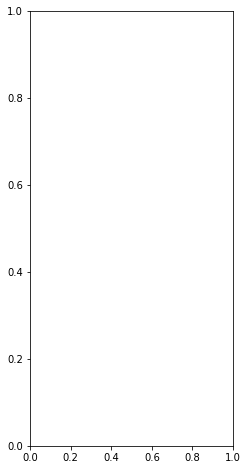

In [127]:
plot_acc_loss(history_augmented,6)
plt.savefig("accurancy and loss model whit augmented data");

2985/2985 [==============================] - 2s 713us/step
loss: 2.09
accuracy: 0.41


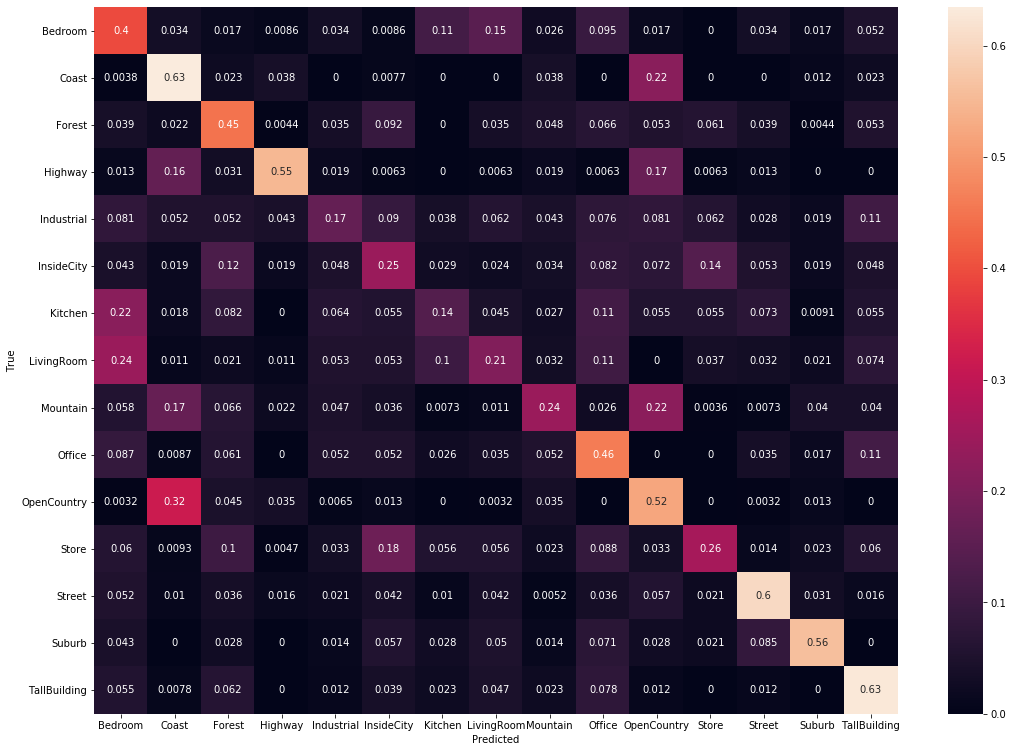

In [128]:
y_pred_aug = model1().predict_classes(test_r_x)
loss0,accuracy0 = model1().evaluate(test_r_x,y_test_one_hot)
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

plot_confusion_matrix(test_y,y_pred_aug)
plt.savefig("confusion matrix first model");

#### batch normalization

Add batch normalization layers before the reLU layers

In [178]:
def model_norm():
    model_norm = Sequential([
        Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
        BatchNormalization(axis=-1),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Conv2D(16, 3,strides=1, padding='same'),
        BatchNormalization(axis=-1),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Conv2D(32, 3,strides=1, padding='same'),
        BatchNormalization(axis=-1),
        Activation('relu'),
        Flatten(),
        Dense(num_classes,kernel_initializer=norm, bias_initializer='zeros'),
        Activation('softmax')
    ])
    sgd = ks.optimizers.SGD(momentum=0.7,nesterov=True)
    model_norm.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ['accuracy'])
    return model_norm

In [179]:
history_norm=model_norm().fit(
    X_train,
    y_train,
    batch_size=batch_sz,
    epochs=20,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

Train on 1275 samples, validate on 225 samples
Epoch 1/20
1088/1275 [========================>.....] - ETA: 0s - loss: 3.1604 - accuracy: 0.2528

KeyboardInterrupt: 

As we can see from the accurancy in the training set this model is probably affected by overfitting.

In [132]:
#plot_acc_loss(history_norm,16)
plt.savefig("accurancy and loss model after adding batch normalization layers");

<Figure size 432x288 with 0 Axes>

2985/2985 [==============================] - 3s 1ms/step
loss: 4.35
accuracy: 0.10


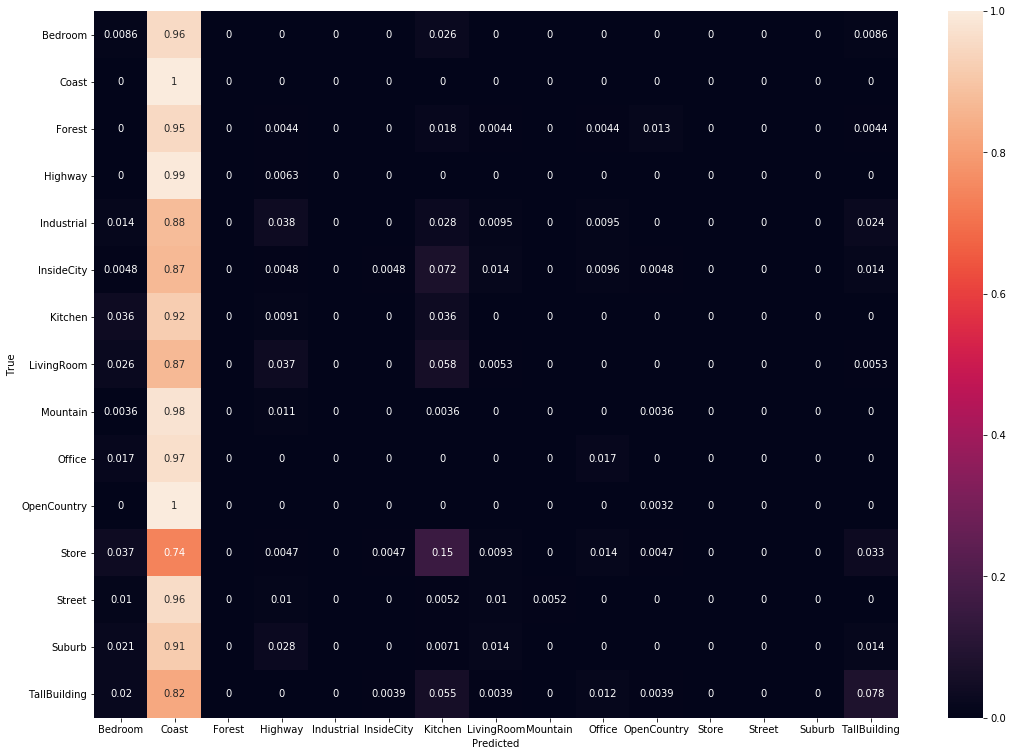

In [133]:
y_pred_norm = model_norm().predict_classes(test_r_x)
loss0,accuracy0 = model_norm().evaluate(test_r_x,y_test_one_hot)
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

plot_confusion_matrix(test_y,y_pred_norm)
plt.savefig("confusion matrix first model");

Since we get bad results we try train this model with the augmented data to reduce the overfitting.

In [134]:
history_norm_data_augmeted=model_norm().fit(
    train_improved,
    epochs=20,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

Epoch 1/20
40/40 [==============================] - 5s 115ms/step - loss: 0.9327 - accuracy: 0.7169 - val_loss: 3.1322 - val_accuracy: 0.2267
Epoch 2/20
40/40 [==============================] - 5s 125ms/step - loss: 0.6943 - accuracy: 0.7890 - val_loss: 4.2274 - val_accuracy: 0.1289
Epoch 3/20
40/40 [==============================] - 5s 118ms/step - loss: 0.5055 - accuracy: 0.8557 - val_loss: 2.6217 - val_accuracy: 0.3022
Epoch 4/20
40/40 [==============================] - 5s 117ms/step - loss: 0.3336 - accuracy: 0.9184 - val_loss: 3.5868 - val_accuracy: 0.2222
Epoch 5/20
40/40 [==============================] - 5s 124ms/step - loss: 0.2547 - accuracy: 0.9341 - val_loss: 2.7492 - val_accuracy: 0.3644
Epoch 6/20
40/40 [==============================] - 5s 121ms/step - loss: 0.1723 - accuracy: 0.9671 - val_loss: 2.2884 - val_accuracy: 0.3644
Epoch 7/20
40/40 [==============================] - 5s 132ms/step - loss: 0.1484 - accuracy: 0.9663 - val_loss: 2.0505 - val_accuracy: 0.4311
Epoch 

In [135]:
y_pred_norm_data_augmeted = model_norm().predict_classes(test_r_x)
loss0,accuracy0 = model_norm().evaluate(test_r_x,y_test_one_hot)
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

2985/2985 [==============================] - 4s 1ms/step
loss: 1.44
accuracy: 0.60


As we can see the performance is remacable increase, so from now we will use data augmented to train our model.

#### Add and Resize convolutional filters

Increase the support of convolutional filters as we move from input to output:
3×3, 5×5, 7×7

In [181]:
def model_res():
    model_res = Sequential([
        Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Conv2D(16, 3,strides=1, padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Conv2D(16, 5,strides=1, padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Conv2D(32, 7,strides=1, padding='same'),
        Activation('relu'),
        Flatten(),
        Dense(num_classes,kernel_initializer=norm, bias_initializer='zeros'),
        Activation('softmax')
    ])
    model_res.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ['accuracy'])
    return model_res

In [138]:
history_res=model_res().fit(
    train_improved,
    epochs=30,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

Epoch 1/30
40/40 [==============================] - 4s 103ms/step - loss: 2.7090 - accuracy: 0.0549 - val_loss: 2.7089 - val_accuracy: 0.0844
Epoch 2/30
40/40 [==============================] - 4s 96ms/step - loss: 2.7066 - accuracy: 0.0682 - val_loss: 2.7083 - val_accuracy: 0.0667
Epoch 3/30
40/40 [==============================] - 4s 102ms/step - loss: 2.7037 - accuracy: 0.0894 - val_loss: 2.7062 - val_accuracy: 0.0667
Epoch 4/30
40/40 [==============================] - 4s 103ms/step - loss: 2.7002 - accuracy: 0.0910 - val_loss: 2.7015 - val_accuracy: 0.0800
Epoch 5/30
40/40 [==============================] - 4s 98ms/step - loss: 2.6924 - accuracy: 0.0949 - val_loss: 2.6943 - val_accuracy: 0.1022
Epoch 6/30
40/40 [==============================] - 4s 97ms/step - loss: 2.6751 - accuracy: 0.1357 - val_loss: 2.6539 - val_accuracy: 0.1556
Epoch 7/30
40/40 [==============================] - 4s 110ms/step - loss: 2.6246 - accuracy: 0.1553 - val_loss: 2.6068 - val_accuracy: 0.0933
Epoch 8/3

In [139]:
#plot_acc_loss(history_res,6)
plt.savefig("accurancy and loss model after resizing layers");

<Figure size 432x288 with 0 Axes>

2985/2985 [==============================] - 3s 897us/step
loss: 1.90
accuracy: 0.41


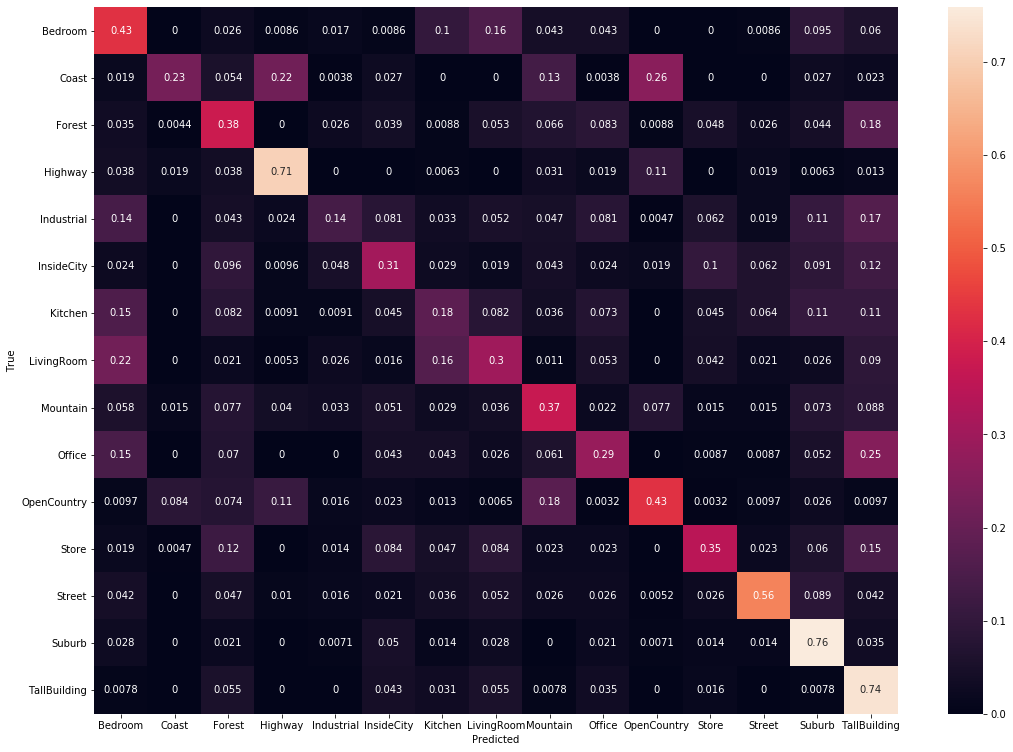

In [140]:
y_pred_res = model_res().predict_classes(test_r_x)
loss0,accuracy0 = model_res().evaluate(test_r_x,y_test_one_hot)
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

plot_confusion_matrix(test_y,y_pred_res)
plt.savefig("confusion matrix res model");

As we can see this optimized tecnique seems not to bring improvements. Probably this is because small kernel can detects more relevant features. But considering the accurancy this model seems to be far from overfitting, for that reasons we add a batch normalization layer after the first convolutional layers.

We try to run normalize model with these kind of manipulation

In [182]:
def model_res_norm():
    model_res_norm = Sequential([
        Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
        BatchNormalization(axis=-1),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Conv2D(16, 3,strides=1, padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Conv2D(16, 5,strides=1, padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Conv2D(32, 7,strides=1, padding='same'),
        Activation('relu'),
        Flatten(),
        Dense(num_classes,kernel_initializer=norm, bias_initializer='zeros'),
        Activation('softmax')
    ])
    model_res_norm.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ['accuracy'])
    return model_res_norm

In [144]:
history_res_norm=model_res_norm().fit(
    train_improved,
    epochs=30,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

Epoch 1/30
40/40 [==============================] - 6s 148ms/step - loss: 2.6691 - accuracy: 0.1075 - val_loss: 2.6847 - val_accuracy: 0.1244
Epoch 2/30
40/40 [==============================] - 5s 124ms/step - loss: 2.4253 - accuracy: 0.2290 - val_loss: 2.6389 - val_accuracy: 0.1689
Epoch 3/30
40/40 [==============================] - 5s 123ms/step - loss: 2.2234 - accuracy: 0.2878 - val_loss: 2.6899 - val_accuracy: 0.0622
Epoch 4/30
40/40 [==============================] - 5s 121ms/step - loss: 2.1204 - accuracy: 0.3286 - val_loss: 2.6154 - val_accuracy: 0.0978
Epoch 5/30
40/40 [==============================] - 5s 124ms/step - loss: 1.9620 - accuracy: 0.3757 - val_loss: 2.5691 - val_accuracy: 0.1556
Epoch 6/30
40/40 [==============================] - 5s 123ms/step - loss: 1.8644 - accuracy: 0.4071 - val_loss: 2.5466 - val_accuracy: 0.1600
Epoch 7/30
40/40 [==============================] - 6s 141ms/step - loss: 1.6488 - accuracy: 0.4722 - val_loss: 2.1959 - val_accuracy: 0.3422
Epoch 

2985/2985 [==============================] - 4s 1ms/step
loss: 6.47
accuracy: 0.19


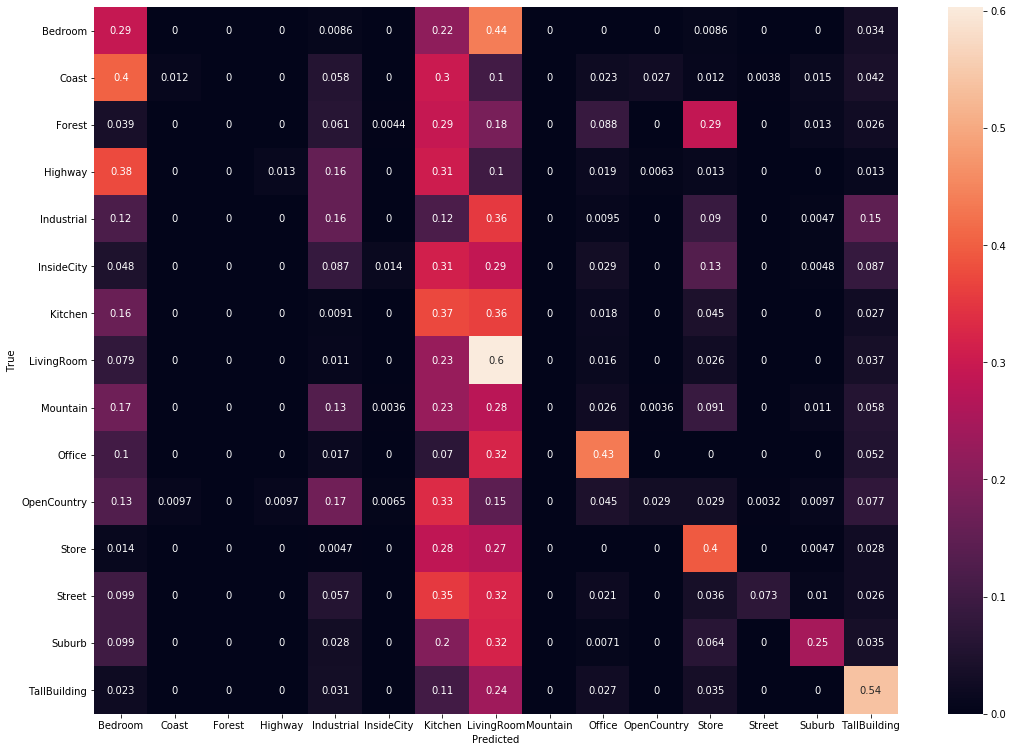

In [145]:
y_pred_res_norm = model_res_norm().predict_classes(test_r_x)
loss0,accuracy0 = model_res_norm().evaluate(test_r_x,y_test_one_hot)
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

plot_confusion_matrix(test_y,y_pred_res_norm)
plt.savefig("confusion matrix res model");

#### Optimization parameter change

Weight regularization provides an approach to reduce the overfitting of a deep learning neural network model on the training data and improve the performance of the model on new data, such as the holdout test set.

There are multiple types of weight regularization, such as L1 and L2 vector norms, and each requires a hyperparameter that must be configured. In our case we add a l2 regularizer on layers.

In [183]:
from keras.regularizers import l2
def model_opt_not_resized():
    model_opt_not_resized = Sequential([
        Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Conv2D(16, 3,strides=1, padding='same',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Conv2D(32, 3,strides=1, padding='same',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        Activation('relu'),
        Flatten(),
        Dense(num_classes, activation='softmax',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))
    ])
    model_opt_not_resized.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model_opt_not_resized

We also switch to the Adam optimizer.

In [148]:
history_opt_not_resized=model_opt_not_resized().fit(
    train_improved,
    epochs=30,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

Epoch 1/30
40/40 [==============================] - 3s 86ms/step - loss: 3.0360 - accuracy: 0.0761 - val_loss: 2.8658 - val_accuracy: 0.0711
Epoch 2/30
40/40 [==============================] - 3s 81ms/step - loss: 2.7263 - accuracy: 0.1639 - val_loss: 2.6253 - val_accuracy: 0.2178
Epoch 3/30
40/40 [==============================] - 3s 82ms/step - loss: 2.4617 - accuracy: 0.2651 - val_loss: 2.3786 - val_accuracy: 0.2667
Epoch 4/30
40/40 [==============================] - 3s 78ms/step - loss: 2.3032 - accuracy: 0.3224 - val_loss: 2.2642 - val_accuracy: 0.3333
Epoch 5/30
40/40 [==============================] - 3s 75ms/step - loss: 2.2203 - accuracy: 0.3678 - val_loss: 2.3056 - val_accuracy: 0.2978
Epoch 6/30
40/40 [==============================] - 3s 75ms/step - loss: 2.1964 - accuracy: 0.3608 - val_loss: 2.2867 - val_accuracy: 0.3556
Epoch 7/30
40/40 [==============================] - 4s 88ms/step - loss: 2.1723 - accuracy: 0.3788 - val_loss: 2.2771 - val_accuracy: 0.3022
Epoch 8/30
40

In [149]:
#plot_acc_loss(history_opt,13)
plt.savefig("accurancy and loss model after resizing layers");

<Figure size 432x288 with 0 Axes>

2985/2985 [==============================] - 2s 668us/step
loss: 2.10
accuracy: 0.42


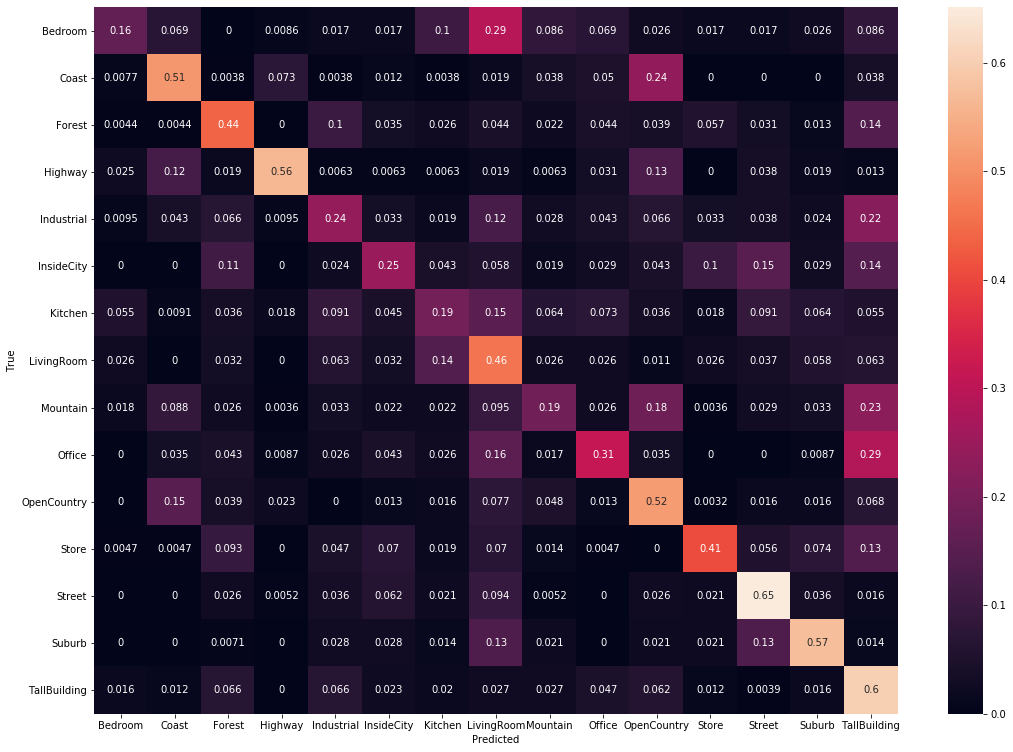

In [151]:
y_pred_opt_not_resized = model_opt_not_resized().predict_classes(test_r_x)
loss0,accuracy0 = model_opt_not_resized().evaluate(test_r_x,y_test_one_hot)
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

plot_confusion_matrix(test_y,y_pred_opt_not_resized)
plt.savefig("confusion matrix res model");

We got better performance with the previous model trained with data augmented so we want to see if it will perform better try with Adam optimizer. 

In [152]:
model_res_norm.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [153]:
history_opt_resized_norm=model_res_norm().fit(
    train_improved,
    epochs=30,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

Epoch 1/30
40/40 [==============================] - 6s 146ms/step - loss: 0.4704 - accuracy: 0.8541 - val_loss: 2.0869 - val_accuracy: 0.5156
Epoch 2/30
40/40 [==============================] - 5s 115ms/step - loss: 0.2812 - accuracy: 0.9035 - val_loss: 2.0785 - val_accuracy: 0.5156
Epoch 3/30
40/40 [==============================] - 5s 118ms/step - loss: 0.2315 - accuracy: 0.9325 - val_loss: 1.9793 - val_accuracy: 0.5644
Epoch 4/30
40/40 [==============================] - 5s 115ms/step - loss: 0.1887 - accuracy: 0.9373 - val_loss: 2.4187 - val_accuracy: 0.5067
Epoch 5/30
40/40 [==============================] - 4s 112ms/step - loss: 0.1637 - accuracy: 0.9467 - val_loss: 2.0181 - val_accuracy: 0.5378
Epoch 6/30
40/40 [==============================] - 5s 119ms/step - loss: 0.1662 - accuracy: 0.9506 - val_loss: 2.4427 - val_accuracy: 0.5022
Epoch 7/30
40/40 [==============================] - 6s 150ms/step - loss: 0.1136 - accuracy: 0.9718 - val_loss: 2.5084 - val_accuracy: 0.5200
Epoch 

2985/2985 [==============================] - 4s 1ms/step
loss: 3.02
accuracy: 0.48


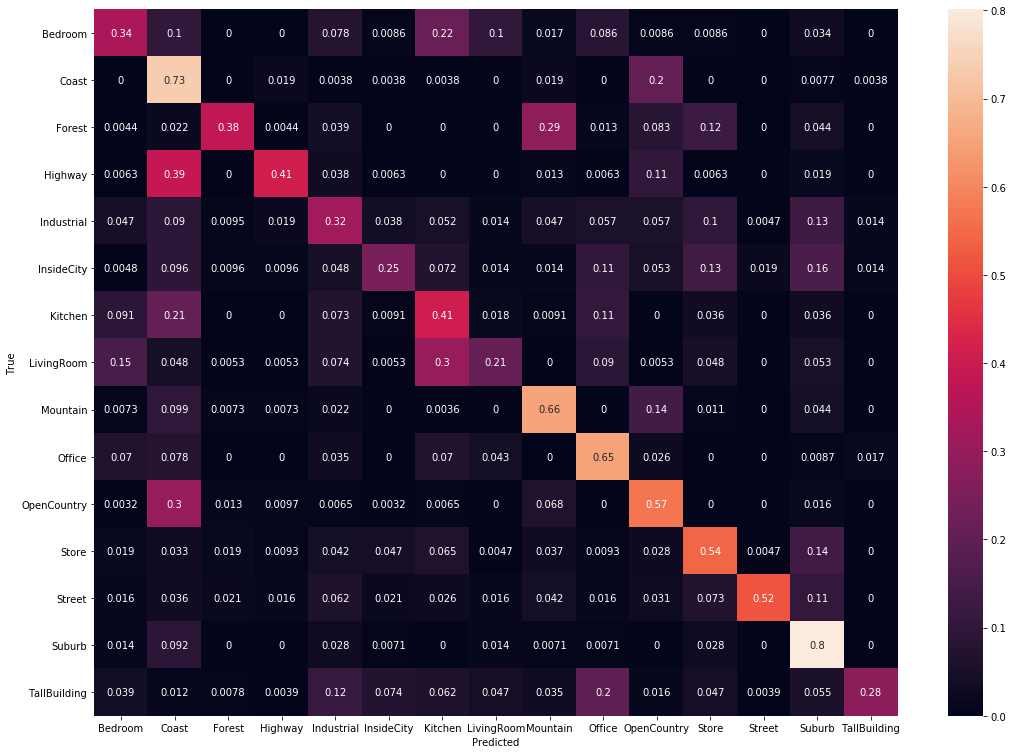

In [154]:
y_pred_opt_resized_norm = model_res_norm().predict_classes(test_r_x)
loss0,accuracy0 = model_res_norm().evaluate(test_r_x,y_test_one_hot)
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

plot_confusion_matrix(test_y,y_pred_opt_resized_norm)
plt.savefig("confusion matrix res model");

We get one of the best accurancy but with a high loss. And also our data seams to by affected by overfitting because the training accuracy is increasing linearly over time, whereas validation accuracy stalls.

#### Dropout

We add some dropout layer to improve regularization. This is technique to reduce overfitting is to introduce dropout to the network. It is a form of regularization that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples

In [184]:
def model_dr():
    model_dr = Sequential([
        Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
        BatchNormalization(axis=-1),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Dropout(0.2),
        Conv2D(16, 3,strides=1, padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Dropout(0.2),
        Conv2D(16, 5,strides=1, padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Dropout(0.2),
        Conv2D(32, 7,strides=1, padding='same'),
        Activation('relu'),
        Flatten(),
        Dense(num_classes,kernel_initializer=norm, bias_initializer='zeros'),
        Activation('softmax')
    ])
    model_dr.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model_dr

In [157]:
history_dr=model_dr().fit(
    train_improved,
    epochs=30,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

Epoch 1/30
40/40 [==============================] - 6s 145ms/step - loss: 2.6960 - accuracy: 0.0729 - val_loss: 2.7068 - val_accuracy: 0.0756
Epoch 2/30
40/40 [==============================] - 7s 164ms/step - loss: 2.4150 - accuracy: 0.2165 - val_loss: 2.7194 - val_accuracy: 0.0711
Epoch 3/30
40/40 [==============================] - 6s 149ms/step - loss: 2.1350 - accuracy: 0.2965 - val_loss: 2.7443 - val_accuracy: 0.0667
Epoch 4/30
40/40 [==============================] - 6s 148ms/step - loss: 2.0158 - accuracy: 0.3608 - val_loss: 2.7125 - val_accuracy: 0.0978
Epoch 5/30
40/40 [==============================] - 6s 142ms/step - loss: 1.8643 - accuracy: 0.3859 - val_loss: 2.7690 - val_accuracy: 0.0978
Epoch 6/30
40/40 [==============================] - 5s 136ms/step - loss: 1.6951 - accuracy: 0.4322 - val_loss: 2.5451 - val_accuracy: 0.1244
Epoch 7/30
40/40 [==============================] - 6s 152ms/step - loss: 1.5684 - accuracy: 0.4808 - val_loss: 2.4827 - val_accuracy: 0.1422
Epoch 

In [158]:
#plot_acc_loss(history_dr,18)
plt.savefig("accurancy and loss model after dropout");

<Figure size 432x288 with 0 Axes>

2985/2985 [==============================] - 4s 1ms/step
loss: 2.67
accuracy: 0.37


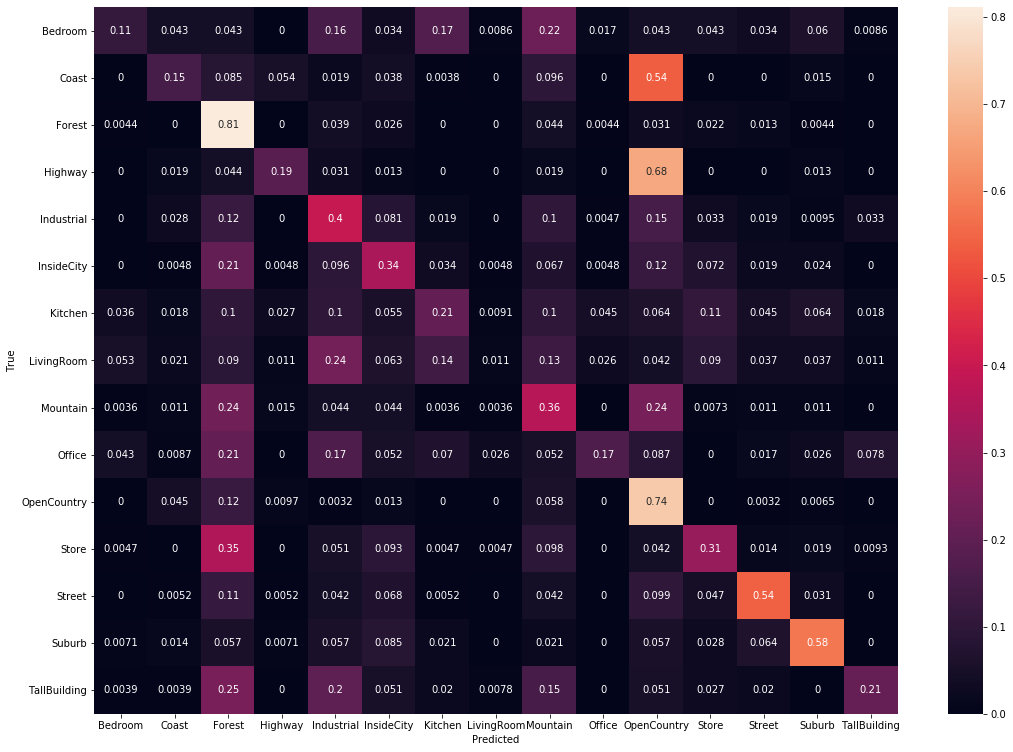

In [159]:
y_pred_dr = model_dr().predict_classes(test_r_x)
loss0,accuracy0 = model_dr().evaluate(test_r_x,y_test_one_hot)
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

plot_confusion_matrix(test_y,y_pred_dr)
plt.savefig("confusion matrix res model");

As we can the results are probably affected also this time by over fitting.

In [208]:
def model_drmod():
    model_dr_mod = Sequential([
        Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
        BatchNormalization(axis=-1),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Dropout(0.2),
        Conv2D(16, 3,strides=1, padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Dropout(0.2),
        Conv2D(32, 5,strides=1, padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Dropout(0.2),
        Flatten(),
        Dense(num_classes,kernel_initializer=norm, bias_initializer='zeros'),
        Activation('softmax')
    ])
    model_dr_mod.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model_drmod

In [162]:
history_drmod=model_drmod().fit(
    train_improved,
    epochs=30,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

Epoch 1/30
40/40 [==============================] - 6s 156ms/step - loss: 2.6324 - accuracy: 0.1420 - val_loss: 2.6733 - val_accuracy: 0.1511
Epoch 2/30
40/40 [==============================] - 6s 148ms/step - loss: 2.3390 - accuracy: 0.2620 - val_loss: 2.6176 - val_accuracy: 0.1511
Epoch 3/30
40/40 [==============================] - 6s 151ms/step - loss: 2.0724 - accuracy: 0.3373 - val_loss: 2.5831 - val_accuracy: 0.1600
Epoch 4/30
40/40 [==============================] - 6s 138ms/step - loss: 1.8039 - accuracy: 0.4259 - val_loss: 2.4574 - val_accuracy: 0.2622
Epoch 5/30
40/40 [==============================] - 6s 158ms/step - loss: 1.5699 - accuracy: 0.4996 - val_loss: 2.3464 - val_accuracy: 0.2756
Epoch 6/30
40/40 [==============================] - 6s 141ms/step - loss: 1.3976 - accuracy: 0.5498 - val_loss: 2.2916 - val_accuracy: 0.2533
Epoch 7/30
40/40 [==============================] - 6s 139ms/step - loss: 1.2969 - accuracy: 0.5718 - val_loss: 2.2109 - val_accuracy: 0.2978
Epoch 

2985/2985 [==============================] - 4s 1ms/step
loss: 2.00
accuracy: 0.48


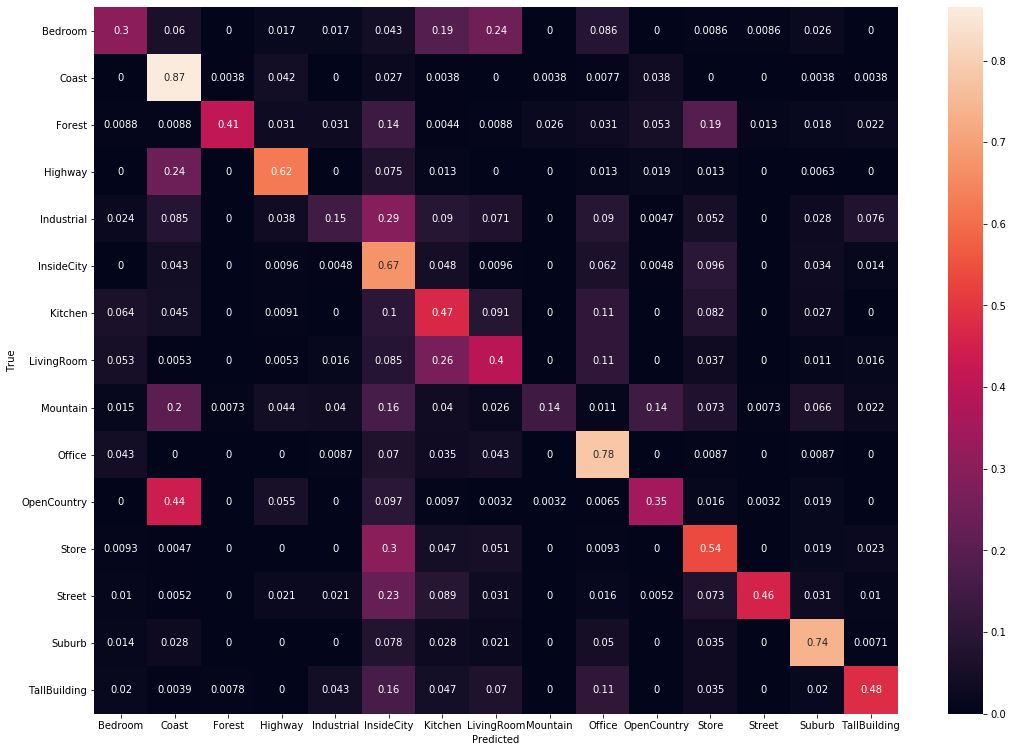

In [163]:
y_pred_dr_mod = model_dr_mod().predict_classes(test_r_x)
loss0,accuracy0 = model_dr_mod().evaluate(test_r_x,y_test_one_hot)
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

plot_confusion_matrix(test_y,y_pred_dr_mod)
plt.savefig("confusion matrix res model");

Combining the tecniques we get one of the best score.

#### Ensemble of networks

The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses. So we try to combine our previously models.

In [206]:
from keras.utils.vis_utils import plot_model
import scipy
from sklearn.model_selection import train_test_split # to split our train data into train and validation sets
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
np.random.seed(13) # My lucky number

md=[]
md.append(model_norm())
md.append(model_res_norm())
md.append(model_opt_not_resized())
md.append(model_dr())
md.append(model_drmod())

In [211]:
len(md)

6

In [212]:
models=[]
# Start multiple model training with the batch size
for i in range(len(md)):    
    md[i].fit(
    train_improved,
    epochs=30,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
    )
    models.append(md[i])

Epoch 1/30
40/40 [==============================] - 7s 170ms/step - loss: 3.1137 - accuracy: 0.2416 - val_loss: 2.8258 - val_accuracy: 0.0578
Epoch 2/30
40/40 [==============================] - 6s 144ms/step - loss: 1.5239 - accuracy: 0.5263 - val_loss: 3.2055 - val_accuracy: 0.0711
Epoch 3/30
40/40 [==============================] - 6s 140ms/step - loss: 0.9769 - accuracy: 0.6894 - val_loss: 3.6488 - val_accuracy: 0.1067
Epoch 4/30
40/40 [==============================] - 6s 146ms/step - loss: 0.7522 - accuracy: 0.7733 - val_loss: 3.4282 - val_accuracy: 0.1333
Epoch 5/30
40/40 [==============================] - 5s 137ms/step - loss: 0.5275 - accuracy: 0.8580 - val_loss: 4.0148 - val_accuracy: 0.1600
Epoch 6/30
40/40 [==============================] - 6s 143ms/step - loss: 0.4112 - accuracy: 0.8973 - val_loss: 3.1941 - val_accuracy: 0.2000
Epoch 1/30
40/40 [==============================] - 8s 194ms/step - loss: 2.6331 - accuracy: 0.1412 - val_loss: 2.6698 - val_accuracy: 0.1200
Epoch 

AttributeError: 'function' object has no attribute 'fit'

In [250]:
# Predict labels with models
lb = []
for m in models:
    predicts = m.predict_classes(test_r_x)
    lb.append(predicts)
    
# Ensemble with voting
lb = np.array(lb)
lb = np.transpose(lb)
lb = scipy.stats.mode(lb,axis=1)[0]
#lb = np.squeeze(lb)

In [251]:
lb

array([[ 7],
       [ 1],
       [ 7],
       ...,
       [ 1],
       [14],
       [14]], dtype=int64)

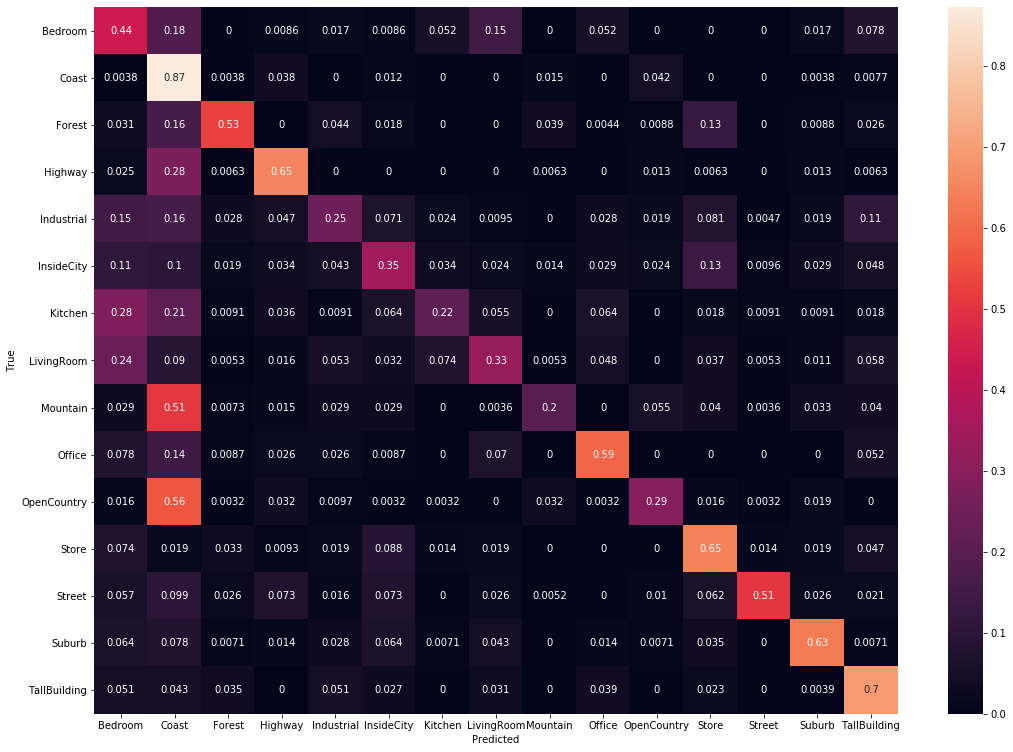

In [252]:
plot_confusion_matrix(test_y,lb)
plt.savefig("confusion matrix res model");

In [1]:
from sklearn.metrics import classification_report
print('Classification Report')
print(classification_report(test_y, lb, target_names=labels))

Classification Report


NameError: name 'test_y' is not defined